# Analysis on ARIMA Model and Forecasts

### Yifei Cao |          January 26, 2023

## ARIMA Model

In [144]:
# Import ARIMA Packages

# pip install fredapi
# pip install pmdarima
import numpy as np
import pandas as pd
import pmdarima
import yfinance as yf
import datetime
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import fredapi
from fredapi import Fred
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as st

### Import Data

In [119]:
# import data
data = pd.read_csv('A1_JPYUSD.csv', parse_dates=True, index_col=0)
data.head()

,Japan
1985-01-01,0.003927
1985-02-01,0.003854
1985-03-01,0.003960
1985-04-01,0.003964
1985-05-01,0.003971


### Data Overview

<AxesSubplot:>

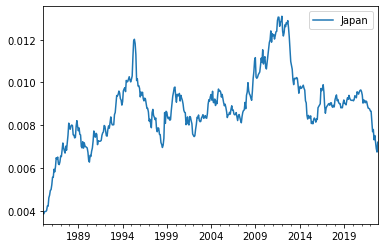

In [120]:
data.plot()

### Splitting Data into Training and Testing Data

In [121]:
print(data.shape)
train = data.iloc[:364]
test = data.iloc[364:]

print(train.shape, test.shape)

(455, 1)
(364, 1) (91, 1)


<AxesSubplot:>

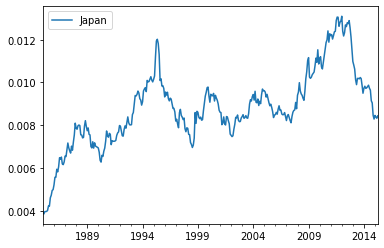

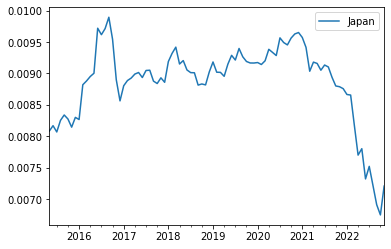

In [122]:
train.plot()
test.plot()

### Find the Orders Using Training Dataset


In [123]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller

In [124]:
# AR
model1 = ARIMA(train, order=(2,0,0)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Japan   No. Observations:                  364
Model:                 ARIMA(2, 0, 0)   Log Likelihood                2464.017
Date:                Thu, 26 Jan 2023   AIC                          -4920.034
Time:                        15:40:24   BIC                          -4904.446
Sample:                    01-01-1985   HQIC                         -4913.839
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.000     19.781      0.000       0.008       0.010
ar.L1          1.0776      0.042     25.546      0.000       0.995       1.160
ar.L2         -0.1008      0.043     -2.363      0.018      -0.184      -0.017
sigma2      7.413e-08   4.21e-09     17.613      0.000    6.59e-08    8.24e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                38.24
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.06
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
# MA
model2 = ARIMA(train, order=(0,0,2)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Japan   No. Observations:                  364
Model:                 ARIMA(0, 0, 2)   Log Likelihood                2143.931
Date:                Thu, 26 Jan 2023   AIC                          -4279.863
Time:                        15:40:27   BIC                          -4264.274
Sample:                    01-01-1985   HQIC                         -4273.667
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.000     84.297      0.000       0.009       0.009
ma.L1          1.3855      0.034     40.455      0.000       1.318       1.453
ma.L2          0.7375      0.034     21.616      0.000       0.671       0.804
sigma2      4.402e-07   2.84e-08     15.506      0.000    3.85e-07    4.96e-07
===================================================================================
Ljung-Box (L1) (Q):                  93.83   Jarque-Bera (JB):                 7.53
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.05   Skew:                             0.06
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
# Test Stationarity
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1. ADF: ', dftest[0])
    print('2. P-val: ', dftest[1])
    print('3. Number of Lags: ', dftest[2])
    print('4. Number of observations used: ', dftest[3])
    print('5. Critical Values: ')
    for key,val in dftest[4].items():
        print('\t', key, ': ', val)
        
ad_test(train['Japan'])

1. ADF:  -2.7960258068289754
2. P-val:  0.058843699553560426
3. Number of Lags:  11
4. Number of observations used:  352
5. Critical Values: 
	 1% :  -3.4490648539347544
	 5% :  -2.8697861692116478
	 10% :  -2.5711631253228306


The p-value is 0.05884 which is slightly greater than the critical level 0.05. Therefore the time series data is not stationary.

In [127]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [128]:
# Comparing all ARIMA models
stepwise_fit = auto_arima(train['Japan'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4916.126, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4915.294, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4916.736, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4916.160, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4916.553, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4917.884, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4915.896, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4915.875, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4915.507, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4913.906, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4919.383, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4918.130, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4917.400, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4917.367, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(2, 1, 0)   Log Likelihood                2462.692
Date:                Thu, 26 Jan 2023   AIC                          -4919.383
Time:                        15:40:34   BIC                          -4907.700
Sample:                    01-01-1985   HQIC                         -4914.739
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0900      0.045      2.018      0.044       0.003       0.177
ar.L2          0.0947      0.050      1.898      0.058      -0.003       0.192
sigma2      7.494e-08   4.22e-09     17.775      0.000    6.67e-08    8.32e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                39.98
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.12
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model is ARIMA(2,1,0)

### Forecast

In [129]:
# fit the model to get the fitted model object
model = ARIMA(train["Japan"].dropna(), order=(2,1,0)).fit()

# Make a 1-month forecast ahead
model.forecast(12)

2015-05-01    0.008443
2015-06-01    0.008454
2015-07-01    0.008455
2015-08-01    0.008456
2015-09-01    0.008456
2015-10-01    0.008457
2015-11-01    0.008457
2015-12-01    0.008457
2016-01-01    0.008457
2016-02-01    0.008457
2016-03-01    0.008457
2016-04-01    0.008457
Freq: MS, Name: predicted_mean, dtype: float64

In [130]:
forecast = model.get_forecast(91)

# get the 90% confidence interval for the forecast
yhat_conf_int = forecast.conf_int(alpha=0.1)
yhat_conf_int["mean"] = forecast.predicted_mean

yhat_conf_int

,lower Japan,upper Japan,mean
2015-05-01,0.007992,0.008893,0.008443
2015-06-01,0.007788,0.009120,0.008454
2015-07-01,0.007599,0.009311,0.008455
2015-08-01,0.007442,0.009471,0.008456
2015-09-01,0.007302,0.009611,0.008456
...,...,...,...
2022-07-01,0.003324,0.013589,0.008457
2022-08-01,0.003295,0.013619,0.008457
2022-09-01,0.003265,0.013648,0.008457
2022-10-01,0.003236,0.013677,0.008457


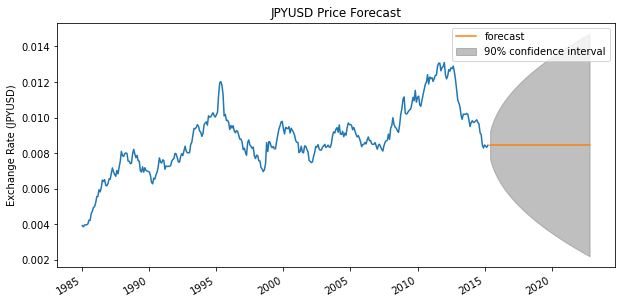

In [132]:
from statsmodels.graphics.tsaplots import plot_predict
# Plot the data and the forecast
fig, ax = plt.subplots(figsize = (10, 5))
plt.title("JPYUSD Price Forecast")
plt.plot(train['Japan'])
plt.ylabel("Exchange Rate (JPYUSD)")
plot_predict(model, ax=ax, start = "2015-06-01", end = "2022-11-01", alpha=0.1)
plt.show()

In [133]:
# Out-of-Sample Forecasting
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    # train_size = int(len(X) * 0.66)
    train, test = X[:364], X[364:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    test = pd.DataFrame(test)
    test["predictions"] = predictions
    return test
y = evaluate_arima_model(data['Japan'], (2,1,0))

In [134]:
print(y)

               Japan  predictions
2015-05-01  0.008081     0.008443
2015-06-01  0.008167     0.008060
2015-07-01  0.008066     0.008140
2015-08-01  0.008251     0.008066
2015-09-01  0.008337     0.008257
...              ...          ...
2022-07-01  0.007519     0.007285
2022-08-01  0.007214     0.007491
2022-09-01  0.006909     0.007208
2022-10-01  0.006746     0.006853
2022-11-01  0.007205     0.006702

[91 rows x 2 columns]


### Generating an Equity Plot of Returns

In [138]:
# compute whether we are going long or short
y["Signals"] = np.where(y["predictions"]>y['Japan'].shift(), 1,-1)

# get the series of log returns
y["returns"] = np.log(y["Japan"]/y["Japan"].shift())

# compute the long and short returns
# Note that we do not have to actually shift signals because the signals are automatically matched
# with the correcponding return in loop when forecasts are made
y["strategy returns"] = y["Signals"]*y["returns"]

# convert to simple returns
y["Cumulative Returns"] = (np.exp(y["strategy returns"].cumsum())-1)*100

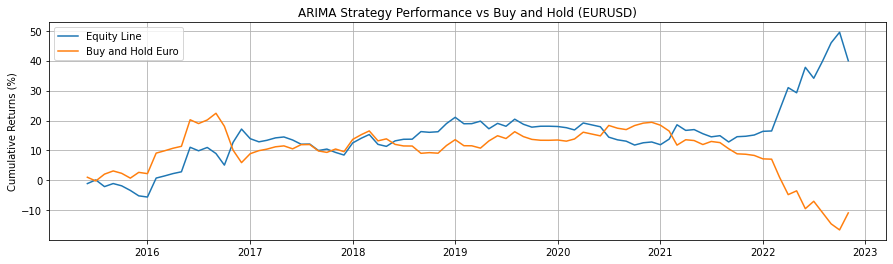

In [107]:
plt.figure(figsize = (15, 4))
plt.plot(y["Cumulative Returns"])
plt.plot((np.exp(y["returns"].cumsum())-1)*100)
plt.ylabel("Cumulative Returns (%)")
plt.title("ARIMA Strategy Performance vs Buy and Hold (EURUSD)")
plt.legend(["Equity Line", "Buy and Hold Euro"])
plt.grid()

### Continuously compounded and annualized returns

In [108]:
# compounded
P = 1000000
A = (((y["Cumulative Returns"]/100)+1)*P)[-1]
t = (len(y)/12)
CCROR = np.log(A/P)/t
print(CCROR*100)

4.433704663592737


In [109]:
# Annualized 
((A/P)**(1/t)-1)*100

4.533462203765626

In [110]:
CCROR*100

4.433704663592737

# 2

<AxesSubplot:xlabel='date'>

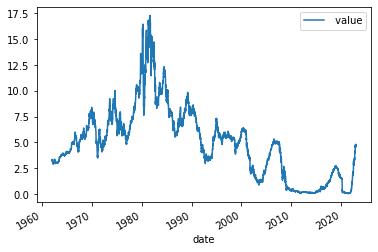

In [158]:
rf_rate = pd.read_csv('1-year-treasury-rate-yield-chart.csv', parse_dates=True, index_col='date')
# Data Overview
rf_rate.plot()

In [152]:
# Returns and Forecasts

y['y_current'] = np.log(y['Japan']) 

y['y_future'] = np.log(y['Japan'].shift(-1))

y['y_change'] = y['y_future'] - y['y_current']

y['y_forecast']=np.log(y['predictions'])

y['y_error']=y['y_current']-y['y_forecast']

y['y_change_fitted']=y['y_forecast']-y['y_current']

In [142]:
y

,Japan,predictions,y_current,y_future,y_change,y_forecast,y_error,y_change_fitted,Signals,returns,strategy returns,Cumulative Returns
2015-05-01,0.008081,0.008443,-4.818263,-4.807703,0.010561,-4.774464,-0.043799,0.043799,-1,NaN,NaN,NaN
2015-06-01,0.008167,0.008060,-4.807703,-4.820040,-0.012337,-4.820848,0.013145,-0.013145,-1,0.010561,-0.010561,-1.050505
2015-07-01,0.008066,0.008140,-4.820040,-4.797442,0.022598,-4.811002,-0.009037,0.009037,-1,-0.012337,0.012337,0.177778
2015-08-01,0.008251,0.008066,-4.797442,-4.787075,0.010367,-4.820083,0.022641,-0.022641,-1,0.022598,-0.022598,-2.060606
2015-09-01,0.008337,0.008257,-4.787075,-4.794716,-0.007641,-4.796708,0.009633,-0.009633,1,0.010367,0.010367,-1.039979
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,0.007519,0.007285,-4.890349,-4.931664,-0.041315,-4.921911,0.031562,-0.031562,-1,0.026927,-0.026927,34.116372
2022-08-01,0.007214,0.007491,-4.931664,-4.974939,-0.043275,-4.894022,-0.037642,0.037642,-1,-0.041315,0.041315,39.773461
2022-09-01,0.006909,0.007208,-4.974939,-4.998833,-0.023894,-4.932504,-0.042435,0.042435,-1,-0.043275,0.043275,45.954915
2022-10-01,0.006746,0.006853,-4.998833,-4.933034,0.065799,-4.983016,-0.015816,0.015816,-1,-0.023894,0.023894,49.484293


In [146]:
### Mean squared errors
## Taylor Rule Model
P = len(y['y_error'])
MSE_T = np.sum(np.square(y['y_error']))/P
MSE_T

0.0006006932840762634

In [147]:
## Random Walk
MSE_R = np.sum(np.square(y['y_change']))/P
MSE_R

0.0005809296335330899

### DMW test

In [150]:
### DMW Statistic
error_R = y['y_change'].reset_index(drop=True)
error_T = y['y_error'].reset_index(drop=True)
tmp = np.square(error_R)-np.square(error_T)-(MSE_R-MSE_T)
# V_hat
v_hat = np.sum(np.square(tmp))/P
# Statistic
DMW = (MSE_R-MSE_T)/np.sqrt(v_hat/P)
print(DMW)

-0.1279849314566616


In [ ]:
# If the absolute value of the t-value is greater than the critical value, you reject the null hypothesis.
# The t-critical value is 1.64

Since the absolute value of -0.12798 is less than the critical value, we fail to reject the null hypothesis that the MP model does not outperform the random walk model. And we can conclude that the MP model has the possibility to not outperform the random walk model.

### Clark-West test

In [151]:
# CW Statistic
tmp2 = np.sum(np.square(y['y_change_fitted']))/P
CW = (MSE_R-MSE_T+tmp2)/np.sqrt(v_hat/P)
print(CW)

3.7619689321291503


Since the CW statistic is 3.7619689 which is greater than the critical value 1.64, we can reject the null hypothesis that MP model does not outperform the random walk model. And we can conclude that the MP model outperformed the random walk model.

### Sharp Ratio of the Strategy

In [159]:
rf_rate.head()

,value
date,
1962-01-02,3.22
1962-01-03,3.24
1962-01-04,3.24
1962-01-05,3.26
1962-01-08,3.31


In [164]:
# match index and dates with our data
drange = pd.date_range(start = "05/2015", end = "12/2022", freq = "M")
y.index = drange

y["rf"] = rf_rate

# Take the first value for each year out of the data
rfs = y["rf"].resample("Y").first()[1:-1]

# Calculate the annualized return
t = len(rfs)
rfp = ((((rfs/100)+1).cumprod()[-1])**(1/t)-1)
print(rfp)

0.012214472324448389


In [165]:
# add the monthly risk free rate to our data
y["rf"] = rf_rate
y["rf"] = y["rf"].ffill()

In [167]:
# Subset strategy returns
return_frame = y[["strategy returns"]].copy().dropna()

# Subset the monthly rate of return for rthe risk free rate
return_frame["rf"] = (y[["rf"]].dropna()/100+1)**(1/12)-1

excess_return = return_frame["strategy returns"]- return_frame["rf"]

# annualized return method (some use the arithmetic return, which is less conservative)
annualized_excess = ((excess_return+1).prod()**(12/len(y))-1)*100
annualized_excess

2.9096762202158732

In [169]:
# calculate the annualized standard deviation
excess_ann_std = excess_return.std()*np.sqrt(12)*100

(annualized_excess)/excess_ann_std

0.3496040668755394

In [170]:
def sharpe_ratio(returns, rfr):
    excess_returns = returns - rfr
    n = len(excess_returns)
    mean = excess_returns.mean()
    std = np.sqrt(np.sum(np.square(excess_returns))/(n-1))
    return(mean/std)

# alternative common method
n = len(excess_return)
mean = excess_return.mean()
std = np.sqrt(np.sum(np.square(excess_return))/(n-1))
mean/std*np.sqrt(12)

0.38696068731555044